In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xesmf
from glob import glob
from utils import fix_crocotime

In [11]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('../HINDCAST/OUTPUT/crococeazah_avg_*.nc')
croco     = xr.open_mfdataset(crocopath)['temp']
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst = croco.isel(s_rho=-1).load().where(grid.mask_rho==1)


In [20]:
grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('/ceaza/lucas/storage/CROCO/OUTPUT/TIDESTEST1/*.nc')
croco     = xr.open_mfdataset(crocopath)['temp']
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst2 = croco.isel(s_rho=-1).load().where(grid.mask_rho==1)

grid = xr.open_dataset('../HINDCAST/CROCO_FILES/crococeazah_grd.nc')
crocopath = glob('/ceaza/lucas/storage/CROCO/OUTPUT/TIDESTEST2/*.nc')
croco     = xr.open_mfdataset(crocopath)['temp']
croco     = fix_crocotime(croco, YORIG='1950-01-01 00:00:00')
croco.coords['lon_rho'] = (croco.lon_rho+180)%360-180
sst3 = croco.isel(s_rho=-1).load().where(grid.mask_rho==1)

In [13]:
mercator = xr.open_mfdataset('~/storage/FORECAST/4DPHYSICS/HINDCAST/2022*')
sstmercator = mercator['thetao'].isel(depth=0).load()

In [14]:
ostia = xr.open_mfdataset('~/storage/OSTIA/2022*').sel(lon=slice(-75.5,-70.5), lat=slice(-33.7,-27.3)).analysed_sst.load().reindex({'time':sst.time.values}, method='nearest')-273.15

In [22]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(sst3.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst3 = regridder(sst3)

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [27]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(sst2.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst2      = regridder(sst2)


/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [15]:
reference        = ostia.copy()
husk             = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                      'lon':(['lon'], reference.lon.values, reference.lon.attrs)})
regridder = xesmf.Regridder(sst.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
sst       = regridder(sst)


regridder = xesmf.Regridder(sstmercator.rename({'latitude':'lat', 'longitude':'lon'}), reference, 'bilinear')
sstmercator = regridder(sstmercator)


/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/xesmf/frontend.py:597: UserWarning: Using dimensions ('latitude', 'longitude') from data variable thetao as the horizontal dimensions for the regridding.
  warnings.warn(


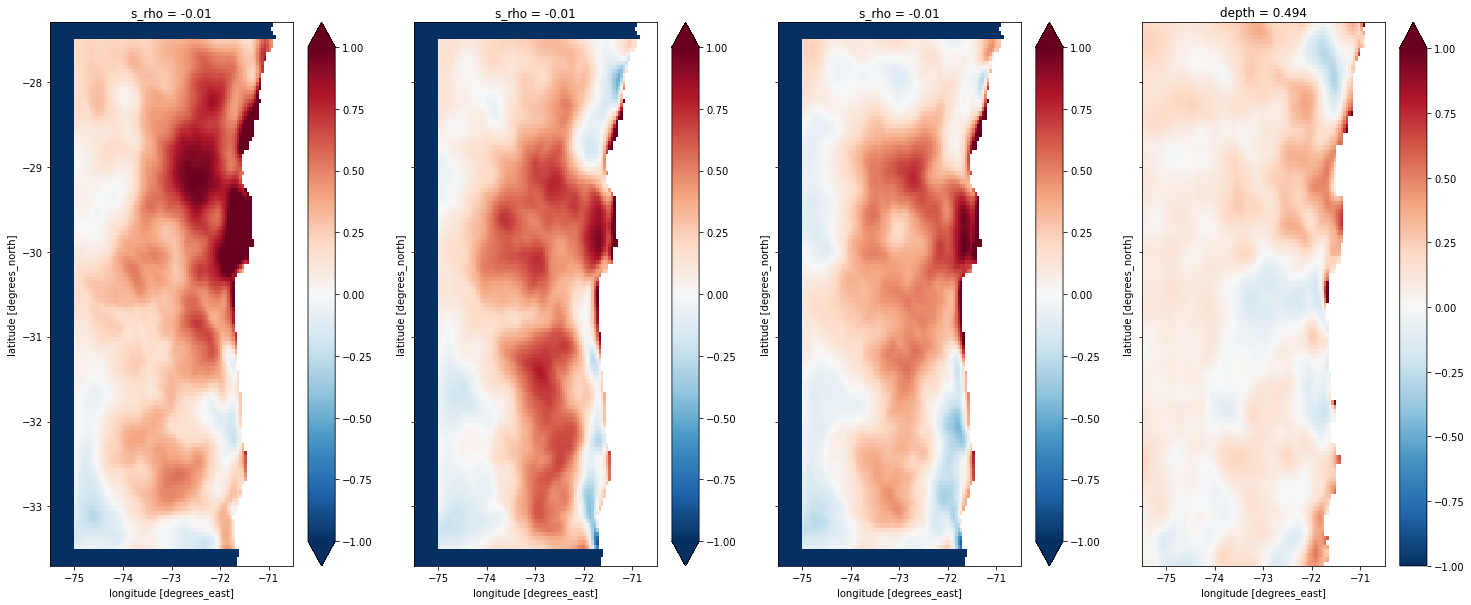

In [30]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(25,10))
(sst-reference).mean('time').plot(ax=ax[0], cmap='RdBu_r', vmin=-1, vmax=1)
(sst2-reference).mean('time').plot(ax=ax[1], cmap='RdBu_r', vmin=-1, vmax=1)
(sst3-reference).mean('time').plot(ax=ax[2], cmap='RdBu_r', vmin=-1, vmax=1)
(sstmercator.resample({'time':'d'}).mean().reindex({'time':ostia.time.values}, method='nearest')-reference).mean('time').plot(ax=ax[3], vmin=-1, vmax=1, cmap='RdBu_r')

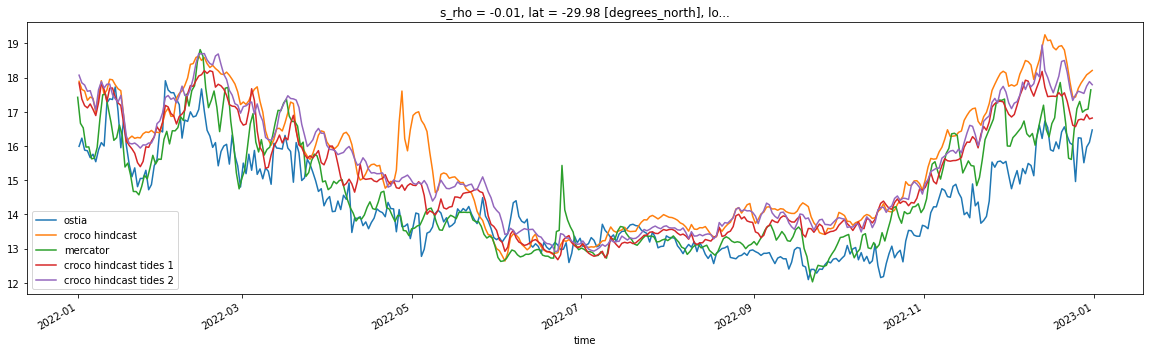

In [35]:
plt.figure(figsize=(20,5))
lat,lon = -30.0,-71.5
ostia.sel(lat=lat, lon=lon, method='nearest').plot(label='ostia')
sst.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast')
sstmercator.sel(lat=lat, lon=lon, method='nearest').resample({'time':'d'}).mean().plot(label='mercator')
sst2.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast tides 1')
sst3.sel(lat=lat, lon=lon, method='nearest').plot(label='croco hindcast tides 2')
plt.legend()
